# Evaluation

## TODOs

* run the evaluation for the larger wiki dataset but for only 1 epoch

In [108]:
import json
import pandas as pd
import matplotlib


def read_and_prepare(measurement_path: str, experiment_key: str) -> list[dict]:
    # Using readlines()
    with open(measurement_path, 'r') as fp:
        lines = fp.readlines()

    
    lines = [json.loads(line[11:].replace("'", "\"")) for line in lines if "\'rank\'" in line]

    for line in lines:
        line["experiment_key"] = experiment_key
        

    #lines = [line[11:].replace("'", "\"") for line in lines if "\'rank\'" in line]
    return lines

In [109]:
measurements_paths = {"rank_7": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext2/icde_2024_experiments_ranks_7.log",
                      "rank_6": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext2/icde_2024_experiments_ranks_6.log",
                      "rank_5": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext2/icde_2024_experiments_ranks_5.log",
                      "rank_4": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext2/icde_2024_experiments_ranks_4.log",
                      "rank_3": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext2/icde_2024_experiments_ranks_3.log",
                      "rank_2": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext2/icde_2024_experiments_ranks_2.log",
                      "rank_1": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext2/icde_2024_experiments_ranks_1.log"
                      }

measurements_paths = {"rank_7": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext103/icde_2024_experiments_ranks_7.log",
                      "rank_6": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext103/icde_2024_experiments_ranks_6.log",
                      "rank_5": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext103/icde_2024_experiments_ranks_5.log",
                      "rank_4": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext103/icde_2024_experiments_ranks_4.log",
                      "rank_3": "/scratch/repositories/mlgym/icde_paper/runtime_experiments/results/wikitext103/icde_2024_experiments_ranks_3.log",

                      }

In [110]:
from itertools import chain


lines_grouped = [read_and_prepare(measurement_path=path, experiment_key=experiment_key) for experiment_key, path in measurements_paths.items()]

# flattening the list
lines = list(chain.from_iterable(lines_grouped))


df_data = pd.DataFrame(lines)
df_data.head()

,rank,key,duration,experiment_key
0,2,train_forward_pass,1.314139,rank_7
1,2,train_post_processing,0.000108,rank_7
2,6,train_forward_pass,1.405351,rank_7
3,6,train_post_processing,0.000325,rank_7
4,3,train_forward_pass,1.417871,rank_7


In [111]:
set(df_data["key"])

{'checkpointing',
 'eval_aggregate_and_calc',
 'eval_epoch',
 'eval_forward_pass',
 'eval_post_processing',
 'total_experiment_time',
 'train_backward_pass',
 'train_epoch',
 'train_forward_pass',
 'train_optimizer_step',
 'train_post_processing'}

## Total experiment time

In [112]:
df_total_experiment_time = df_data[df_data["key"] == "total_experiment_time"].groupby(by="experiment_key").max()
df_total_experiment_time.head()

,rank,key,duration
experiment_key,,,
rank_3,2,total_experiment_time,5712.066233
rank_4,3,total_experiment_time,4391.016014
rank_5,4,total_experiment_time,3521.656605
rank_6,5,total_experiment_time,2953.423505
rank_7,6,total_experiment_time,2538.976962


<Axes: xlabel='experiment_key'>

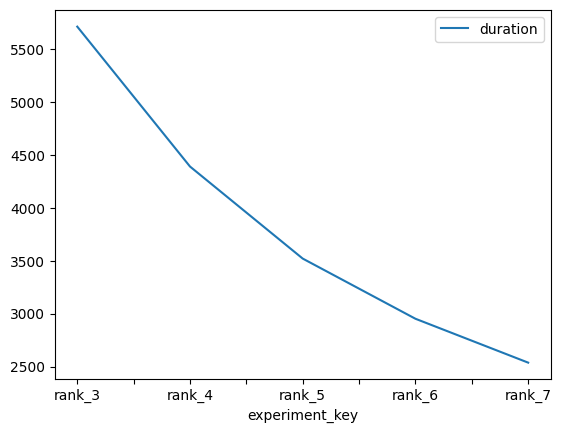

In [113]:
df_total_experiment_time.drop(labels=["rank"], axis=1).plot()

## Runtime of rank 0 process

we consider the rank 0 process as it runs additional tasks e.g., checkpointing, metrics and loss calculations etc. 
We measure the runtime at different granularities. 

1. step routines (forward pass, backward pass and optimizer step)
2. Measuring the training time and evaluation for a given epoch from outside 
3. Measuring the total experiment time from outside

This way, we can measure the inefficiencies that are added due to the framework at different levels. The accumulated time in the step routines determines the amount spend on the GPU calculations and provide a minimum runtime bound.

In [114]:
df_summed = df_data.groupby(by=["experiment_key", "key", "rank"]).sum().reset_index()
df_summed[df_summed["key"]=="eval_forward_pass"].head()

,experiment_key,key,rank,duration
9,rank_3,eval_forward_pass,0,966.686209
10,rank_3,eval_forward_pass,1,980.845402
11,rank_3,eval_forward_pass,2,978.816042
45,rank_4,eval_forward_pass,0,725.558560
46,rank_4,eval_forward_pass,1,736.950768


In [115]:
# {'checkpointing',
#  'eval_aggregate_and_calc',
#  'eval_epoch',
#  'eval_forward_pass',
#  'eval_post_processing',
#  'total_experiment_time',
#  'train_backward_pass',
#  'train_epoch',
#  'train_forward_pass',
#  'train_optimizer_step',
#  'train_post_processing'}



sum_keys_dict = {
    "checkpointing": ["checkpointing"],
    "steps": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step'],
    "steps+pp": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing'],
    "steps+pp+eval": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'eval_aggregate_and_calc'],
    "steps+pp+eval+cp": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'eval_aggregate_and_calc', 'checkpointing'],
    "epochs": ['checkpointing', 'eval_epoch', 'train_epoch'],
    "total": ["total_experiment_time"]
}

rank = 0

df_list = []

for label_key, sum_keys in sum_keys_dict.items():
    df_summed_filtered = df_summed[df_summed["key"].isin(sum_keys)]
    df_summed_filtered = df_summed_filtered[df_summed_filtered["rank"] == rank]
    df_raw_calc_time = df_summed_filtered.groupby("experiment_key").sum().drop(labels=["rank", "key"], axis=1).rename(columns={"duration": f"{label_key}"})
    df_list.append(df_raw_calc_time)

from functools import reduce
df_durations = reduce(lambda df1,df2: pd.merge(df1,df2,on='experiment_key'), df_list)
df_durations

,checkpointing,steps,steps+pp,steps+pp+eval,steps+pp+eval+cp,epochs,total
experiment_key,,,,,,,
rank_3,90.692941,4866.628768,4866.934307,5289.159558,5379.852499,5700.268372,5712.066233
rank_4,89.847030,3640.634668,3640.837867,3958.953286,4048.800316,4379.931446,4391.016014
rank_5,94.633992,2913.130657,2913.322632,3173.388985,3268.022977,3510.304312,3521.656605
rank_6,92.055528,2442.305583,2442.465714,2665.540781,2757.596310,2941.344459,2953.423505
rank_7,89.943057,2132.931183,2133.062531,2313.249923,2403.192980,2525.739201,2538.976962


In [116]:
df_durations

,checkpointing,steps,steps+pp,steps+pp+eval,steps+pp+eval+cp,epochs,total
experiment_key,,,,,,,
rank_3,90.692941,4866.628768,4866.934307,5289.159558,5379.852499,5700.268372,5712.066233
rank_4,89.847030,3640.634668,3640.837867,3958.953286,4048.800316,4379.931446,4391.016014
rank_5,94.633992,2913.130657,2913.322632,3173.388985,3268.022977,3510.304312,3521.656605
rank_6,92.055528,2442.305583,2442.465714,2665.540781,2757.596310,2941.344459,2953.423505
rank_7,89.943057,2132.931183,2133.062531,2313.249923,2403.192980,2525.739201,2538.976962


Plot shows time measurements with different granularities. 

Plot shows the time measurements regarding the time spend in steps (train forward, train backward, and eval forward, without checkpointing), epochs (train and evaluation of epoch, and checkpointing) and the total time to solution measured from outside. All these measures are done for GPU rank 0, which does the heavy work during the checkpointing and therefore has the longest "uptime". 

We see that duration_total and duration_epochs almost overlaps, showing that the component instantiation and logging only add neglegible overhead. 

Interestingly, duration_steps_with_checkpointing has a lower runtime in comparison duration_epochs (which includes checkpointing as well). This means that further computations such a the metrics calculation during training and network socket communication add to the runtime as well of up to X%. 

Apart from the first epoch, the checkpointing duration is independent of the number of GPUs used. For DDP, the gradient synchronization and weight updates before the checkpointing, thus only a single model (here, rank 0) needs to be transmitted to the REST endpoint. Noteworthily, in the DDP case we have some inefficiencies due to Accelerate forcing us to the temporarily storing the model on disc, reading the binary stream of the stored files and then sending those to the server. This overhead causes a 5.3 times higher transmission time in comparison to directly sending the in-memory components to the server as done in the single-GPU case. Especially for smaller datasets and larger models, this can cause significant GPU idle time in relative to the overall compute of the experiment.  

TODO: Check if the evaluation part takes some time as well 

<Axes: xlabel='experiment_key'>

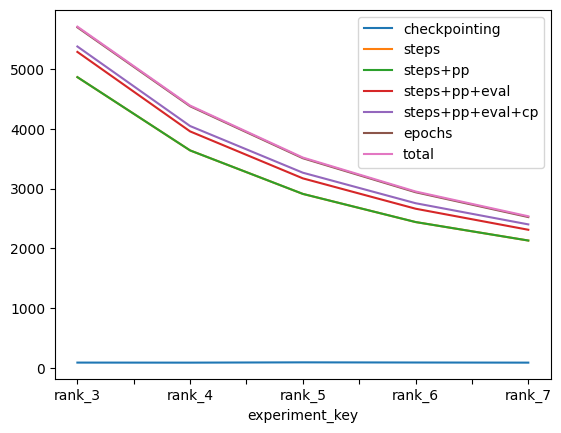

In [117]:
df_durations.plot()

In [118]:
sum_keys_dict = {
    "eval_forward_pass": ["eval_forward_pass"],
    "train_backward_pass": ["train_backward_pass"],
    "train_forward_pass": ["train_forward_pass"],
    "train_optimizer_step": ["train_optimizer_step"],
    # "eval_post_processing": ["eval_post_processing"],
    # "train_post_processing": ["train_post_processing"],
    "checkpointing": ["checkpointing"],
    "eval_aggregate_and_calc": ["eval_aggregate_and_calc"],

#    "steps+pp+eval": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'eval_aggregate_and_calc'],
 #   "steps+pp+eval+cp": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'eval_aggregate_and_calc', 'checkpointing'],
    "epochs": ['checkpointing', 'eval_epoch', 'train_epoch'],
    "total": ["total_experiment_time"]
}

rank = 0

df_list = []

for label_key, sum_keys in sum_keys_dict.items():
    df_summed_filtered = df_summed[df_summed["key"].isin(sum_keys)]
    df_summed_filtered = df_summed_filtered[df_summed_filtered["rank"] == rank]
    df_raw_calc_time = df_summed_filtered.groupby("experiment_key").sum().drop(labels=["rank", "key"], axis=1).rename(columns={"duration": f"{label_key}"})
    df_list.append(df_raw_calc_time)

from functools import reduce
df_durations = reduce(lambda df1,df2: pd.merge(df1,df2,on='experiment_key'), df_list)
df_durations

,eval_forward_pass,train_backward_pass,train_forward_pass,train_optimizer_step,checkpointing,eval_aggregate_and_calc,epochs,total
experiment_key,,,,,,,,
rank_3,966.686209,2825.859231,1033.300958,40.782370,90.692941,422.225251,5700.268372,5712.066233
rank_4,725.558560,2108.688293,776.421907,29.965908,89.847030,318.115419,4379.931446,4391.016014
rank_5,580.547453,1682.991355,624.823364,24.768485,94.633992,260.066353,3510.304312,3521.656605
rank_6,484.040989,1421.187629,516.973110,20.103856,92.055528,223.075067,2941.344459,2953.423505
rank_7,425.758279,1237.072902,452.628321,17.471681,89.943057,180.187392,2525.739201,2538.976962


<Axes: xlabel='experiment_key'>

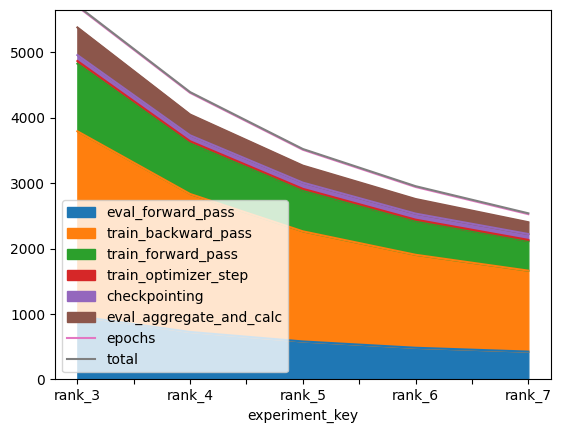

In [119]:
ax = df_durations[["eval_forward_pass", "train_backward_pass", "train_forward_pass", "train_optimizer_step", "checkpointing", "eval_aggregate_and_calc"]].plot.area()
df_durations[["epochs", "total"]].plot(ax=ax)

## Cummulated runtime difference between single GPU training and multi-gpu training

We for each experiment_key and key we sum up the durations. We then subtract single-gpu durations from  the multi-gpu durations. 
This unveils the computational overhead induced by multi-gpu training. Despite the latter being faster, multi-gpu training is more efficient due to less syncing operations.


In [120]:
filtered_cols = {'checkpointing',
                'eval_forward_pass',
                'train_backward_pass',
                'train_forward_pass',
                'train_optimizer_step'}

filtered_cols = {'checkpointing',
 'eval_aggregate_and_calc',
 'eval_epoch',
 'eval_forward_pass',
 'eval_post_processing',
 'total_experiment_time',
 'train_backward_pass',
 'train_epoch',
 'train_forward_pass',
 'train_optimizer_step',
 'train_post_processing'}

df_multi_vs_single = df_summed[df_summed["key"].isin(filtered_cols)].groupby(by=["experiment_key", "key"]).sum().reset_index().drop(labels=["rank"], axis=1)
df_multi_vs_single.head()

,experiment_key,key,duration
0,rank_3,checkpointing,90.753127
1,rank_3,eval_aggregate_and_calc,1240.608570
2,rank_3,eval_epoch,4360.311632
3,rank_3,eval_forward_pass,2926.347653
4,rank_3,eval_post_processing,0.345783


In [121]:
df_single = df_multi_vs_single[df_multi_vs_single["experiment_key"] == "rank_1"]
df_multi = df_multi_vs_single[df_multi_vs_single["experiment_key"] != "rank_1"]

df_multi_vs_single = df_multi.merge(df_single, on="key", suffixes=["_multi", "_single"])

df_multi_vs_single["duration_delta"] = df_multi_vs_single["duration_multi"] - df_multi_vs_single["duration_single"]
df_multi_vs_single#.sort_values(by=["experiment_key_multi"])

,experiment_key_multi,key,duration_multi,experiment_key_single,duration_single,duration_delta


In [122]:
sum_keys_dict = {
    "eval_forward_pass": ["eval_forward_pass"],
    "train_backward_pass": ["train_backward_pass"],
    "train_forward_pass": ["train_forward_pass"],
    "train_optimizer_step": ["train_optimizer_step"],
    # "eval_post_processing": ["eval_post_processing"],
    # "train_post_processing": ["train_post_processing"],
    "checkpointing": ["checkpointing"],
    "eval_aggregate_and_calc": ["eval_aggregate_and_calc"],

#    "steps+pp+eval": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'eval_aggregate_and_calc'],
 #   "steps+pp+eval+cp": ['eval_forward_pass', 'train_backward_pass', 'train_forward_pass', 'train_optimizer_step', 'eval_post_processing', 'train_post_processing', 'eval_aggregate_and_calc', 'checkpointing'],
    "epochs": ['checkpointing', 'eval_epoch', 'train_epoch'],
    "total": ["total_experiment_time"]
}

df_list = []

for label_key, sum_keys in sum_keys_dict.items():
    df_summed_filtered = df_multi_vs_single[df_multi_vs_single["key"].isin(sum_keys)]
    # df_summed_filtered = df_summed_filtered[df_summed_filtered["rank"] == rank]
    df_raw_calc_time = df_summed_filtered.groupby("experiment_key_multi").sum().drop(labels=["key", 'duration_multi', 'duration_single', 'experiment_key_single'], axis=1).rename(columns={"duration_delta": f"{label_key}"})
    df_list.append(df_raw_calc_time)

from functools import reduce
df_durations = reduce(lambda df1,df2: pd.merge(df1,df2,on='experiment_key_multi'), df_list)
df_durations

,eval_forward_pass,train_backward_pass,train_forward_pass,train_optimizer_step,checkpointing,eval_aggregate_and_calc,epochs,total
experiment_key_multi,,,,,,,,


<Axes: xlabel='experiment_key_multi'>

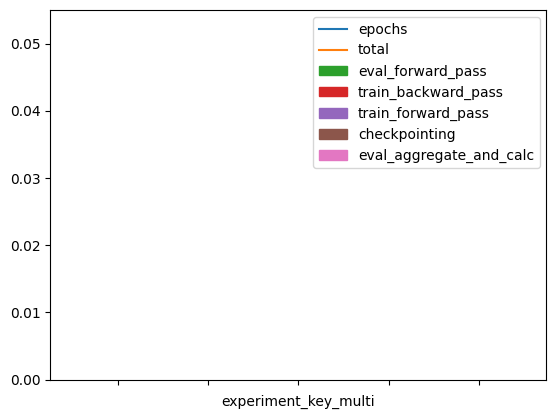

In [123]:
ax= df_durations[["epochs", "total"]].plot()
df_durations[["eval_forward_pass", "train_backward_pass", "train_forward_pass", "checkpointing", "eval_aggregate_and_calc"]].plot.area(ax=ax)
